In [1]:
!unzip -q "/content/drive/MyDrive/SurgeryDatasets/brain-dataset.zip" -d /content/
!ls /content/brain_dataset


ls: cannot access '/content/brain_dataset': No such file or directory


In [1]:
# ===============================
# 🚀 Imports
# ===============================
import os, cv2, glob, numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F

# ===============================
# 🚀 Helper to load NIfTI
# ===============================
import nibabel as nib
def load_nii(path):
    img = nib.load(path)
    data = img.get_fdata()
    return np.transpose(data, (1,0,2))  # make orientation consistent

In [ ]:
# ===============================
# 🚀 Prepare slices
# ===============================
def extract_slices(image_dir):
    imgs, masks = [], []
    for case in tqdm(os.listdir(image_dir), desc=f"Extracting slices from {image_dir}"):
        case_path = os.path.join(image_dir, case)
        t1_file = next((f for f in os.listdir(case_path) if "_t1.nii" in f), None)
        seg_file = next((f for f in os.listdir(case_path) if "_seg.nii" in f), None)

        if t1_file is None or seg_file is None:
            print(f"Skipping case {case} due to missing T1 or segmentation file.")
            continue

        img = load_nii(os.path.join(case_path, t1_file))
        mask = load_nii(os.path.join(case_path, seg_file))
        img = (img - np.min(img)) / (np.max(img) - np.min(img))

        for i in range(img.shape[2]):
            slice_img = img[:,:,i]
            slice_mask = (mask[:,:,i] > 0).astype(np.float32)
            if np.sum(slice_mask) > 0:
                imgs.append(slice_img)
                masks.append(slice_mask)
    return imgs, masks

train_imgs, train_masks = extract_slices("/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData")
test_imgs, test_masks = extract_slices("/content/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData")

print(f"✅ Total slices: train={len(train_imgs)}, test={len(test_masks)}")
print(f"⚡ Successfully loaded {len(imgs)} slices after skipping {skipped_cases} incomplete cases.")


Extracting slices from /content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData:  35%|███▌      | 130/371 [00:33<01:45,  2.28it/s]

In [ ]:

# ===============================
# 🚀 Dataset
# ===============================
class BrainSliceDataset(Dataset):
    def __init__(self, imgs, masks):
        self.imgs = imgs
        self.masks = masks

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = cv2.resize(self.imgs[idx], (256,256))
        mask = cv2.resize(self.masks[idx], (256,256))

        img = np.expand_dims(img, axis=0).astype(np.float32)
        mask = np.expand_dims(mask, axis=0).astype(np.float32)
        return torch.tensor(img), torch.tensor(mask)

In [ ]:
# ===============================
# 🚀 DataLoader
# ===============================
max_slices = 8000
dataset = BrainSliceDataset(train_imgs[:max_slices], train_masks[:max_slices])
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)
test_dataset = BrainSliceDataset(test_imgs, test_masks)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:

# 🚀 Model: Heavy ResUNet
# ===============================
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class ResUNet(nn.Module):
    def __init__(self):
        super(ResUNet, self).__init__()
        self.enc1 = DoubleConv(1,64)
        self.enc2 = DoubleConv(64,128)
        self.enc3 = DoubleConv(128,256)
        self.enc4 = DoubleConv(256,512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512,1024)

        self.upconv4 = nn.ConvTranspose2d(1024,512,2,2)
        self.dec4 = DoubleConv(1024,512)
        self.upconv3 = nn.ConvTranspose2d(512,256,2,2)
        self.dec3 = DoubleConv(512,256)
        self.upconv2 = nn.ConvTranspose2d(256,128,2,2)
        self.dec2 = DoubleConv(256,128)
        self.upconv1 = nn.ConvTranspose2d(128,64,2,2)
        self.dec1 = DoubleConv(128,64)

        self.out = nn.Conv2d(64,1,1)

    def forward(self,x):
        e1=self.enc1(x)
        e2=self.enc2(self.pool(e1))
        e3=self.enc3(self.pool(e2))
        e4=self.enc4(self.pool(e3))

        b=self.bottleneck(self.pool(e4))

        d4=self.upconv4(b)
        d4=torch.cat([d4,e4],dim=1)
        d4=self.dec4(d4)

        d3=self.upconv3(d4)
        d3=torch.cat([d3,e3],dim=1)
        d3=self.dec3(d3)

        d2=self.upconv2(d3)
        d2=torch.cat([d2,e2],dim=1)
        d2=self.dec2(d2)

        d1=self.upconv1(d2)
        d1=torch.cat([d1,e1],dim=1)
        d1=self.dec1(d1)

        return torch.sigmoid(self.out(d1))


In [ ]:

# ===============================
# 🚀 Training
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def dice_loss(pred, target, smooth=1):
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))

train_losses, val_losses = [], []
epochs=20
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for img, mask in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        img, mask = img.to(device), mask.to(device)
        pred = model(img)
        bce = F.binary_cross_entropy(pred, mask)
        dloss = dice_loss(pred, mask)
        loss = bce + dloss
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        running_loss += loss.item()
    avg_train = running_loss/len(train_loader)
    train_losses.append(avg_train)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for img, mask in val_loader:
            img, mask = img.to(device), mask.to(device)
            pred = model(img)
            bce = F.binary_cross_entropy(pred, mask)
            dloss = dice_loss(pred, mask)
            val_loss += (bce + dloss).item()
    avg_val = val_loss/len(val_loader)
    val_losses.append(avg_val)
    print(f"📈 Epoch {epoch+1}: Train Loss={avg_train:.4f}, Val Loss={avg_val:.4f}")

In [ ]:

# ===============================
# 🚀 Plotting losses
# ===============================
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend(); plt.show()


In [ ]:

# 🚀 Test set evaluation
# ===============================
model.eval()
test_loss, test_dice = 0, 0
with torch.no_grad():
    for img, mask in test_loader:
        img, mask = img.to(device), mask.to(device)
        pred = model(img)
        bce = F.binary_cross_entropy(pred, mask)
        dloss = dice_loss(pred, mask)
        test_loss += (bce + dloss).item()
        test_dice += (1 - dloss).item()
avg_test_loss = test_loss/len(test_loader)
avg_test_dice = test_dice/len(test_loader)
print(f"🚀 Test Loss: {avg_test_loss:.4f}, Test Dice: {avg_test_dice:.4f}")

In [ ]:

# ===============================
# 🚀 Show predictions on test data
# ===============================
img, mask = next(iter(test_loader))
img = img.to(device)
with torch.no_grad():
    pred = model(img).cpu()

plt.figure(figsize=(15,5))
for i in range(4):
    plt.subplot(3,4,i+1); plt.imshow(img[i][0].cpu(), cmap='gray'); plt.title("Image")
    plt.subplot(3,4,i+5); plt.imshow(mask[i][0], cmap='gray'); plt.title("Mask")
    plt.subplot(3,4,i+9); plt.imshow(pred[i][0], cmap='gray'); plt.title("Pred")
plt.show()

In [ ]:

# ===============================
# 🚀 Save the model
# ===============================
torch.save(model.state_dict(), "/content/brain_model.pt")
print("✅ Saved model to /content/brain_model.pt")


In [2]:
# ============================
# ✅ 1. SETUP
# ============================
import os
import cv2
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("📌 Device:", device)

# Check RAM
!free -h

📌 Device: cuda
               total        used        free      shared  buff/cache   available
Mem:            12Gi       1.3Gi       9.8Gi       2.0Mi       1.5Gi        11Gi
Swap:             0B          0B          0B


In [3]:

# ============================
# ✅ 2. PATHS & PARAMETERS
# ============================
DATA_DIR = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"  # your unzipped path
IMG_SIZE = 128
BATCH_SIZE = 16
EPOCHS = 20
NUM_SLICES = 8000  # cap on slices


In [4]:
# ============================
# ✅ 3. COLLECT FILES
# ============================

import nibabel as nib

def load_nii(path):
    img = nib.load(path)
    data = img.get_fdata()
    return np.transpose(data, (1,0,2))  # make orientation consistent

def extract_slices(image_dir, max_slices=None):
    imgs, masks = [], []
    skipped_cases = 0
    for case in tqdm(os.listdir(image_dir), desc=f"Extracting slices from {image_dir}"):
        if max_slices is not None and len(imgs) >= max_slices:
            break  # Stop extracting if we've reached the limit

        case_path = os.path.join(image_dir, case)
        if not os.path.isdir(case_path):
            continue

        t1_file = None
        seg_file = None
        for f in os.listdir(case_path):
            if "_t1.nii" in f:
                t1_file = f
            elif "_seg.nii" in f:
                seg_file = f

        if t1_file is None or seg_file is None:
            print(f"Skipping case {case} due to missing T1 or segmentation file.")
            skipped_cases += 1
            continue

        try:
            img = load_nii(os.path.join(case_path, t1_file))
            mask = load_nii(os.path.join(case_path, seg_file))
            img = (img - np.min(img)) / (np.max(img) - np.min(img))

            for i in range(img.shape[2]):
                if max_slices is not None and len(imgs) >= max_slices:
                    break # Stop adding slices if we've reached the limit

                slice_img = img[:,:,i]
                slice_mask = (mask[:,:,i] > 0).astype(np.float32)
                if np.sum(slice_mask) > 0:
                    imgs.append(slice_img)
                    masks.append(slice_mask)
        except Exception as e:
            print(f"Error processing case {case}: {e}")
            skipped_cases += 1
            continue

    return imgs, masks, skipped_cases

train_imgs, train_masks, skipped_train = extract_slices(DATA_DIR, max_slices=NUM_SLICES)
# Assuming validation data is in a similar structure
VAL_DATA_DIR = "/content/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData"
val_imgs, val_masks, skipped_val = extract_slices(VAL_DATA_DIR, max_slices=int(NUM_SLICES * 0.2)) # Limit validation set as well


print(f"✅ Total slices: train={len(train_imgs)}, val={len(val_masks)}")
print(f"⚡ Successfully loaded {len(train_imgs) + len(val_imgs)} slices after skipping {skipped_train + skipped_val} incomplete cases.")

Extracting slices from /content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData:  33%|███▎      | 122/371 [00:31<01:04,  3.89it/s]
Extracting slices from /content/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData: 100%|██████████| 127/127 [00:00<00:00, 1915.98it/s]

Skipping case BraTS20_Validation_050 due to missing T1 or segmentation file.
Skipping case BraTS20_Validation_083 due to missing T1 or segmentation file.
Skipping case BraTS20_Validation_067 due to missing T1 or segmentation file.
Skipping case BraTS20_Validation_057 due to missing T1 or segmentation file.
Skipping case BraTS20_Validation_107 due to missing T1 or segmentation file.
Skipping case BraTS20_Validation_072 due to missing T1 or segmentation file.
Skipping case BraTS20_Validation_114 due to missing T1 or segmentation file.
Skipping case BraTS20_Validation_048 due to missing T1 or segmentation file.
Skipping case BraTS20_Validation_123 due to missing T1 or segmentation file.
Skipping case BraTS20_Validation_040 due to missing T1 or segmentation file.
Skipping case BraTS20_Validation_066 due to missing T1 or segmentation file.
Skipping case BraTS20_Validation_104 due to missing T1 or segmentation file.
Skipping case BraTS20_Validation_077 due to missing T1 or segmentation file.

In [1]:
# ============================
# ✅ 4. LIMIT TO NUM_SLICES
# ============================
# The limiting is now done implicitly by not processing all slices in extract_slices
# Keeping this cell but it won't perform any action as the limiting is handled above.
# This is just for clarity in the notebook flow.
pass

In [2]:
# ============================
# ✅ 5. DATASET
# ============================
class BrainDataset(Dataset):
    def __init__(self, imgs, masks):
        self.imgs = imgs
        self.masks = masks

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = cv2.resize(self.imgs[idx], (IMG_SIZE, IMG_SIZE))
        mask = cv2.resize(self.masks[idx], (IMG_SIZE, IMG_SIZE))

        img = np.expand_dims(img, axis=0).astype(np.float32)
        mask = np.expand_dims(mask, axis=0).astype(np.float32)
        return torch.tensor(img), torch.tensor(mask)

# Create datasets using the extracted slices, limiting train_imgs and train_masks to NUM_SLICES
train_dataset = BrainDataset(train_imgs[:NUM_SLICES], train_masks[:NUM_SLICES])
val_dataset = BrainDataset(val_imgs, val_masks)

NameError: name 'Dataset' is not defined

In [3]:
# ============================
# ✅ 6. TRAIN / VAL SPLIT
# ============================
# The data is already split into train and validation sets during slice extraction.
# This cell will now just create the DataLoaders.

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

print(f"✅ Dataset ready: {len(train_dataset)} train, {len(val_dataset)} val")

NameError: name 'DataLoader' is not defined

In [ ]:
# ============================
# ✅ 7. MODEL - HEAVY UNET++
# ============================
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1), nn.ReLU(),
            nn.Conv2d(out_c, out_c, 3, padding=1), nn.ReLU()
        )
    def forward(self, x): return self.net(x)

class UNetPlusPlus(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = DoubleConv(1, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))
        d4 = self.dec4(torch.cat([self.up4(b), e4], 1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], 1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], 1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], 1))
        return torch.sigmoid(self.final(d1))

model = UNetPlusPlus().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def dice_loss(pred, target, smooth=1):
    pred, target = pred.view(-1), target.view(-1)
    intersection = (pred*target).sum()
    return 1 - ((2.*intersection+smooth)/(pred.sum()+target.sum()+smooth)

In [ ]:
# ============================
# ✅ 8. TRAINING LOOP
# ============================
train_losses, val_losses, dice_scores = [], [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss, total_dice = 0, 0
    for img, mask in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
        img, mask = img.to(device), mask.to(device)
        pred = model(img)
        bce = F.binary_cross_entropy(pred, mask)
        dloss = dice_loss(pred, mask)
        loss = bce + dloss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += bce.item()
        total_dice += dloss.item()

    avg_loss = total_loss / len(train_loader)
    avg_dice = total_dice / len(train_loader)
    train_losses.append(avg_loss)
    dice_scores.append(1 - avg_dice)

    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for img, mask in val_loader:
            img, mask = img.to(device), mask.to(device)
            pred = model(img)
            bce = F.binary_cross_entropy(pred, mask)
            dloss = dice_loss(pred, mask)
            val_loss += (bce + dloss).item()
    val_losses.append(val_loss / len(val_loader))

    print(f"✅ Epoch {epoch+1}: Train Loss={avg_loss:.4f}, Dice Score={1-avg_dice:.4f}, Val Loss={val_losses[-1]:.4f}")


In [ ]:
# ============================
# ✅ 9. PLOTS
# ============================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train BCE")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch"), plt.ylabel("Loss"), plt.legend(), plt.title("Loss vs Epoch")

plt.subplot(1,2,2)
plt.plot(dice_scores, label="Dice Score")
plt.xlabel("Epoch"), plt.ylabel("Dice"), plt.legend(), plt.title("Dice vs Epoch")
plt.show()


In [ ]:
# ============================
# ✅ 10. SAMPLE PREDICTIONS
# ============================
model.eval()
img, mask = next(iter(val_loader))
img, mask = img.to(device), mask.to(device)
with torch.no_grad():
    pred = model(img)
for i in range(3):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img[i,0].cpu(), cmap='gray'); plt.title("Image")
    plt.subplot(1,3,2); plt.imshow(mask[i,0].cpu(), cmap='gray'); plt.title("Mask")
    plt.subplot(1,3,3); plt.imshow(pred[i,0].cpu(), cmap='gray'); plt.title("Prediction")
    plt.show()

In [ ]:
# ============================
# ✅ 11. SAVE MODEL
# ============================
torch.save(model.state_dict(), "/content/brain_model.pth")
print("✅ Model saved as brain_model.pth")

🚀 Using device: cuda


Extracting slices from /content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData:  33%|███▎      | 122/371 [00:35<01:11,  3.47it/s]


✅ Total slices extracted: 8000
⚡ Successfully loaded 8000 slices after skipping 0 incomplete cases.
✅ Dataset ready: 7200 train, 800 val


Epoch 1: 100%|██████████| 450/450 [00:34<00:00, 12.96it/s]


✅ Epoch 1: Train BCE=0.3626, Dice=0.1156, Val BCE=0.2501, Val Dice=0.1461


Epoch 2: 100%|██████████| 450/450 [00:33<00:00, 13.36it/s]


✅ Epoch 2: Train BCE=0.2057, Dice=0.2007, Val BCE=0.1693, Val Dice=0.2356


Epoch 3: 100%|██████████| 450/450 [00:34<00:00, 13.15it/s]


✅ Epoch 3: Train BCE=0.1223, Dice=0.3097, Val BCE=0.1004, Val Dice=0.3603


Epoch 4: 100%|██████████| 450/450 [00:34<00:00, 13.17it/s]


✅ Epoch 4: Train BCE=0.0713, Dice=0.4576, Val BCE=0.0533, Val Dice=0.4863


Epoch 5: 100%|██████████| 450/450 [00:34<00:00, 13.21it/s]


✅ Epoch 5: Train BCE=0.0449, Dice=0.6099, Val BCE=0.0368, Val Dice=0.6591


Epoch 6: 100%|██████████| 450/450 [00:34<00:00, 13.19it/s]


✅ Epoch 6: Train BCE=0.0314, Dice=0.7354, Val BCE=0.0324, Val Dice=0.7503


Epoch 7: 100%|██████████| 450/450 [00:34<00:00, 13.17it/s]


✅ Epoch 7: Train BCE=0.0255, Dice=0.8035, Val BCE=0.0270, Val Dice=0.8058


Epoch 8: 100%|██████████| 450/450 [00:34<00:00, 13.22it/s]


✅ Epoch 8: Train BCE=0.0217, Dice=0.8440, Val BCE=0.0229, Val Dice=0.8366


Epoch 9: 100%|██████████| 450/450 [00:34<00:00, 13.23it/s]


✅ Epoch 9: Train BCE=0.0194, Dice=0.8702, Val BCE=0.0207, Val Dice=0.8659


Epoch 10: 100%|██████████| 450/450 [00:34<00:00, 13.20it/s]


✅ Epoch 10: Train BCE=0.0179, Dice=0.8868, Val BCE=0.0200, Val Dice=0.8750


Epoch 11: 100%|██████████| 450/450 [00:34<00:00, 13.18it/s]


✅ Epoch 11: Train BCE=0.0170, Dice=0.8974, Val BCE=0.0190, Val Dice=0.8845


Epoch 12: 100%|██████████| 450/450 [00:34<00:00, 13.22it/s]


✅ Epoch 12: Train BCE=0.0160, Dice=0.9067, Val BCE=0.0183, Val Dice=0.8948


Epoch 13: 100%|██████████| 450/450 [00:34<00:00, 13.17it/s]


✅ Epoch 13: Train BCE=0.0152, Dice=0.9140, Val BCE=0.0181, Val Dice=0.8950


Epoch 14: 100%|██████████| 450/450 [00:34<00:00, 13.13it/s]


✅ Epoch 14: Train BCE=0.0144, Dice=0.9204, Val BCE=0.0171, Val Dice=0.9033


Epoch 15: 100%|██████████| 450/450 [00:33<00:00, 13.24it/s]


✅ Epoch 15: Train BCE=0.0140, Dice=0.9238, Val BCE=0.0184, Val Dice=0.9011


Epoch 16: 100%|██████████| 450/450 [00:34<00:00, 13.17it/s]


✅ Epoch 16: Train BCE=0.0133, Dice=0.9283, Val BCE=0.0149, Val Dice=0.9149


Epoch 17: 100%|██████████| 450/450 [00:34<00:00, 13.17it/s]


✅ Epoch 17: Train BCE=0.0129, Dice=0.9313, Val BCE=0.0172, Val Dice=0.9085


Epoch 18: 100%|██████████| 450/450 [00:34<00:00, 13.23it/s]


✅ Epoch 18: Train BCE=0.0127, Dice=0.9331, Val BCE=0.0155, Val Dice=0.9170


Epoch 19: 100%|██████████| 450/450 [00:34<00:00, 13.15it/s]


✅ Epoch 19: Train BCE=0.0126, Dice=0.9346, Val BCE=0.0178, Val Dice=0.9026


Epoch 20: 100%|██████████| 450/450 [00:34<00:00, 13.19it/s]


✅ Epoch 20: Train BCE=0.0122, Dice=0.9367, Val BCE=0.0145, Val Dice=0.9207


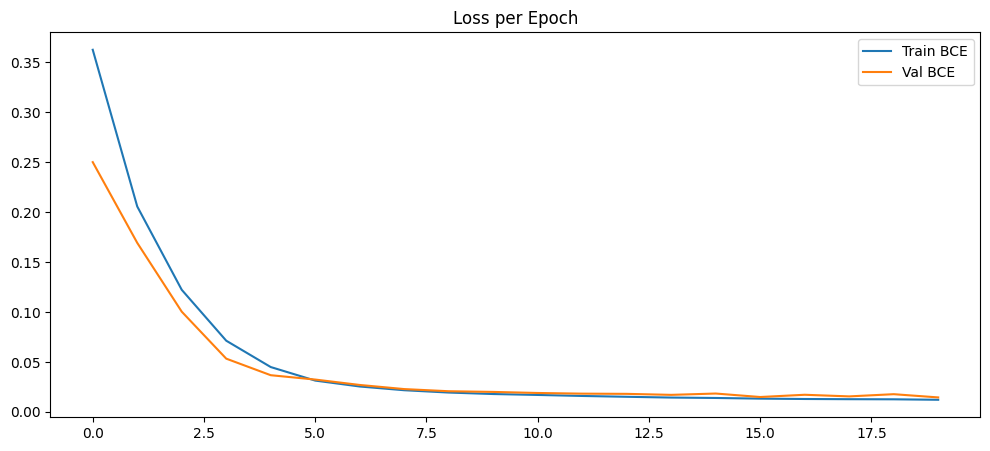

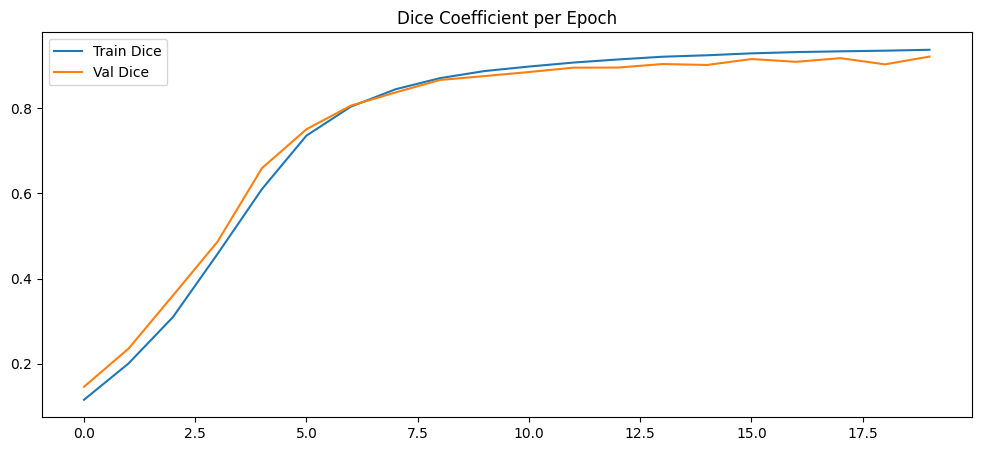

✅ Model saved at /content/brain_model.pth


In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import cv2
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import nibabel as nib

# ✅ GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🚀 Using device:", device)

# ---------------------------------
# ⚙️ Parameters
# ---------------------------------
BATCH_SIZE = 16
EPOCHS = 20
IMAGE_SIZE = 128
NUM_SLICES = 8000 # Cap on slices

# -----------------------
# 🔍 Load dataset paths
# -----------------------
DATA_DIR = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"  # your unzipped path


def load_nii(path):
    img = nib.load(path)
    data = img.get_fdata()
    return np.transpose(data, (1,0,2))  # make orientation consistent

def extract_slices(image_dir, max_slices=None):
    imgs, masks = [], []
    skipped_cases = 0
    for case in tqdm(os.listdir(image_dir), desc=f"Extracting slices from {image_dir}"):
        if max_slices is not None and len(imgs) >= max_slices:
            break  # Stop extracting if we've reached the limit

        case_path = os.path.join(image_dir, case)
        if not os.path.isdir(case_path):
            continue

        t1_file = None
        seg_file = None
        for f in os.listdir(case_path):
            if "_t1.nii" in f:
                t1_file = f
            elif "_seg.nii" in f:
                seg_file = f

        if t1_file is None or seg_file is None:
            print(f"Skipping case {case} due to missing T1 or segmentation file.")
            skipped_cases += 1
            continue

        try:
            img = load_nii(os.path.join(case_path, t1_file))
            mask = load_nii(os.path.join(case_path, seg_file))
            img = (img - np.min(img)) / (np.max(img) - np.min(img))

            for i in range(img.shape[2]):
                if max_slices is not None and len(imgs) >= max_slices:
                    break # Stop adding slices if we've reached the limit

                slice_img = img[:,:,i]
                slice_mask = (mask[:,:,i] > 0).astype(np.float32)
                if np.sum(slice_mask) > 0:
                    imgs.append(slice_img)
                    masks.append(slice_mask)
        except Exception as e:
            print(f"Error processing case {case}: {e}")
            skipped_cases += 1
            continue

    return imgs, masks, skipped_cases

all_imgs, all_masks, skipped_cases = extract_slices(DATA_DIR, max_slices=NUM_SLICES)

print(f"✅ Total slices extracted: {len(all_imgs)}")
print(f"⚡ Successfully loaded {len(all_imgs)} slices after skipping {skipped_cases} incomplete cases.")


# --------------------------
# 📦 Dataset class
# --------------------------
class BrainDataset(Dataset):
    def __init__(self, imgs, masks):
        self.imgs = imgs
        self.masks = masks

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = cv2.resize(self.imgs[idx], (IMAGE_SIZE, IMAGE_SIZE))
        mask = cv2.resize(self.masks[idx], (IMAGE_SIZE, IMAGE_SIZE))

        img = np.expand_dims(img, axis=0).astype(np.float32)
        mask = np.expand_dims(mask, axis=0).astype(np.float32)
        return torch.tensor(img), torch.tensor(mask)

# ✅ Create combined dataset
full_dataset = BrainDataset(all_imgs, all_masks)


# -------------------------
# ✂️ Split 90-10
# -------------------------
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


# --------------------------
# 📊 DataLoaders
# --------------------------
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

print(f"✅ Dataset ready: {len(train_dataset)} train, {len(val_dataset)} val")


# ------------------------------
# 🧩 U-Net++ Model
# ------------------------------
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNetPlusPlus(nn.Module):
    def __init__(self):
        super(UNetPlusPlus, self).__init__()
        self.enc1 = ConvBlock(1, 32)
        self.enc2 = ConvBlock(32, 64)
        self.enc3 = ConvBlock(64, 128)
        self.pool = nn.MaxPool2d(2)
        self.bridge = ConvBlock(128, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = ConvBlock(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = ConvBlock(128, 64)
        self.up0 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec0 = ConvBlock(64, 32)
        self.final = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b = self.bridge(self.pool(e3))
        d2 = self.dec2(torch.cat([self.up2(b), e3], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e2], dim=1))
        d0 = self.dec0(torch.cat([self.up0(d1), e1], dim=1))
        return torch.sigmoid(self.final(d0))

model = UNetPlusPlus().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 🩸 Dice Loss
def dice_loss(pred, target, smooth=1):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))

# ----------------------------
# 🚀 Training
# ----------------------------
train_losses, val_losses = [], []
dice_scores, val_dices = [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss, total_dice = 0, 0
    for img, mask in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        img, mask = img.to(device), mask.to(device)
        pred = model(img)
        bce = F.binary_cross_entropy(pred, mask)
        dloss = dice_loss(pred, mask)
        loss = bce + dloss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += bce.item()
        total_dice += 1 - dloss.item()
    avg_loss = total_loss / len(train_loader)
    avg_dice = total_dice / len(train_loader)
    train_losses.append(avg_loss)
    dice_scores.append(avg_dice)

    # Validation
    model.eval()
    v_loss, v_dice = 0, 0
    with torch.no_grad():
        for img, mask in val_loader:
            img, mask = img.to(device), mask.to(device)
            pred = model(img)
            bce = F.binary_cross_entropy(pred, mask)
            dloss = dice_loss(pred, mask)
            v_loss += bce.item()
            v_dice += 1 - dloss.item()
    val_losses.append(v_loss / len(val_loader))
    val_dices.append(v_dice / len(val_loader))

    print(f"✅ Epoch {epoch+1}: Train BCE={avg_loss:.4f}, Dice={avg_dice:.4f}, Val BCE={val_losses[-1]:.4f}, Val Dice={val_dices[-1]:.4f}")

# -----------------------------
# 📊 Plots
# -----------------------------
plt.figure(figsize=(12,5))
plt.plot(train_losses, label="Train BCE")
plt.plot(val_losses, label="Val BCE")
plt.title("Loss per Epoch")
plt.legend(); plt.show()

plt.figure(figsize=(12,5))
plt.plot(dice_scores, label="Train Dice")
plt.plot(val_dices, label="Val Dice")
plt.title("Dice Coefficient per Epoch")
plt.legend(); plt.show()

# ---------------------------------
# 💾 Save model
# ---------------------------------
torch.save(model.state_dict(), "/content/brain_model.pth")
print("✅ Model saved at /content/brain_model.pth")

In [2]:
# prompt: also delete this file for more space/content/BraTS2020_ValidationData

!rm -r /content/BraTS2020_ValidationData

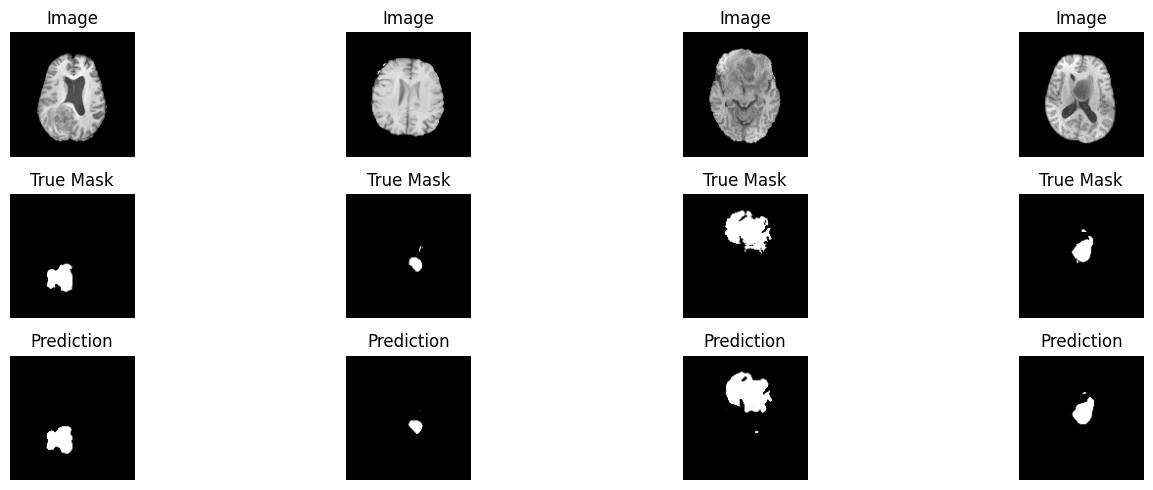

In [4]:
# prompt: give plotting of img with labels of prediction and other

import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
for i in range(4):
    plt.subplot(3,4,i+1)
    plt.imshow(img[i][0].cpu().numpy(), cmap='gray')
    plt.title("Image")
    plt.axis('off')

    plt.subplot(3,4,i+5)
    plt.imshow(mask[i][0].cpu().numpy(), cmap='gray')
    plt.title("True Mask")
    plt.axis('off')

    plt.subplot(3,4,i+9)
    plt.imshow(pred[i][0].cpu().numpy(), cmap='gray')
    plt.title("Prediction")
    plt.axis('off')

plt.tight_layout()
plt.show()